In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import random
random.seed(108448)
from scipy.stats import poisson

#%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB

In [257]:
#Define the number of elememts in each set I, J, K
i_num = 12
k_num = 1
j_num = 100 #Without I and K, so real j_num_real = j_num + i_num + k_num

#Define empty data frames
I = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longtitude'])
J = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longtitude'])
K = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longtitude'])


In [258]:
#Define sets of I, J, K, where J contains I and K

for i in range(i_num):
    I.loc[i, 'Point number'] = 'i'+ str(i)
    I.loc[i, 'Latitude'] = round(random.uniform(0, 100), 4)
    I.loc[i, 'Longtitude'] = round(random.uniform(0, 100), 4)

I.index = I['Point number']
    
    
for k in range(k_num):
    K.loc[k, 'Point number'] = 'k'+ str(k)
    K.loc[k, 'Latitude'] = round(random.uniform(0, 100), 4)
    K.loc[k, 'Longtitude'] = round(random.uniform(0, 100), 4)

K.index = K['Point number']


for j in range(j_num):
    J.loc[j, 'Point number'] = 'j'+ str(j)
    J.loc[j, 'Latitude'] = round(random.uniform(0, 100), 4)
    J.loc[j, 'Longtitude'] = round(random.uniform(0, 100), 4)

J.index = J['Point number'] 
J = pd.concat([J, K], axis = 0) #Include K to J
I.index

Index(['i0', 'i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9', 'i10',
       'i11'],
      dtype='object', name='Point number')

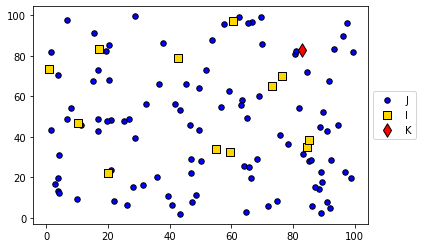

In [259]:
plt.scatter(J['Latitude'], J['Longtitude'], color = 'blue', edgecolors = 'black',
            marker = 'o', s = 30, label = 'J')
plt.scatter(I['Latitude'], I['Longtitude'], color = 'gold', edgecolors = 'black',
            marker = 's', s = 50, label = 'I')
plt.scatter(K['Latitude'], K['Longtitude'], color = 'red', edgecolors = 'black',
            marker = 'd', s = 90, label = 'K')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [260]:
#Define constants

B = 100
S = 50
alpha = 10
beta = 400
q_j = {j: 50 for j in J.index}
mu = 10

Deterministic model

In [261]:
theta_det = {}
for n in range(0, len(list(I.index))):
    theta_det[I.index[n]] = list(poisson.rvs(mu, size = 1))[0]
theta_det

{'i0': 10,
 'i1': 16,
 'i2': 9,
 'i3': 7,
 'i4': 12,
 'i5': 17,
 'i6': 9,
 'i7': 12,
 'i8': 14,
 'i9': 6,
 'i10': 7,
 'i11': 17}

In [262]:
#Define distance matrices

def distance(point1, PointsSet1, point2, PointsSet2):
    c1 = np.array((PointsSet1.loc[point1, 'Latitude'], PointsSet1.loc[point1, 'Longtitude']))
    c2 = np.array((PointsSet2.loc[point2, 'Latitude'], PointsSet2.loc[point2, 'Longtitude']))
    return np.linalg.norm(c1-c2)

dist_JI = {(c1, c2): distance(c1, J, c2, I)for c1, c2 in itertools.product(J.index, I.index)}
dist_IK = {(c1, c2): distance(c1, I, c2, K)for c1, c2 in itertools.product(I.index, K.index)}
dist_KJ = {(c1, c2): distance(c1, K, c2, J)for c1, c2 in itertools.product(K.index, J.index)}
 
dist_KJ


{('k0', 'j0'): 19.61489348454384,
 ('k0', 'j1'): 2.8274921838972396,
 ('k0', 'j2'): 51.52356722529992,
 ('k0', 'j3'): 38.31131457415681,
 ('k0', 'j4'): 71.08473342040469,
 ('k0', 'j5'): 78.34087655828213,
 ('k0', 'j6'): 103.87980460522631,
 ('k0', 'j7'): 54.57864290150498,
 ('k0', 'j8'): 54.55157010627651,
 ('k0', 'j9'): 65.69270593673242,
 ('k0', 'j10'): 31.11795051124029,
 ('k0', 'j11'): 49.23520626868541,
 ('k0', 'j12'): 94.27441108386728,
 ('k0', 'j13'): 77.25796481043233,
 ('k0', 'j14'): 75.39997612101745,
 ('k0', 'j15'): 65.14444738064786,
 ('k0', 'j16'): 75.00547352680336,
 ('k0', 'j17'): 85.74494895100236,
 ('k0', 'j18'): 65.55832460488904,
 ('k0', 'j19'): 79.39515680323328,
 ('k0', 'j20'): 46.49178213340503,
 ('k0', 'j21'): 26.570301804834653,
 ('k0', 'j22'): 31.480245159464683,
 ('k0', 'j23'): 84.28001341243368,
 ('k0', 'j24'): 69.51798803072482,
 ('k0', 'j25'): 26.180062515777152,
 ('k0', 'j26'): 40.90391831524212,
 ('k0', 'j27'): 70.46419477528994,
 ('k0', 'j28'): 60.465440

In [263]:
#Define set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= 0.5*B:
        L.append((k, j))
        
L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j3'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j38'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j48'),
 ('k0', 'j53'),
 ('k0', 'j55'),
 ('k0', 'j61'),
 ('k0', 'j63'),
 ('k0', 'j69'),
 ('k0', 'j71'),
 ('k0', 'j72'),
 ('k0', 'j73'),
 ('k0', 'j75'),
 ('k0', 'j76'),
 ('k0', 'j77'),
 ('k0', 'j79'),
 ('k0', 'j80'),
 ('k0', 'j81'),
 ('k0', 'j82'),
 ('k0', 'j86'),
 ('k0', 'j96'),
 ('k0', 'j97'),
 ('k0', 'k0')]

In [264]:
#Define sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_interim = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_interim.keys())
KJ_feas


[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j3'),
 ('k0', 'j10'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j38'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j48'),
 ('k0', 'j53'),
 ('k0', 'j55'),
 ('k0', 'j61'),
 ('k0', 'j63'),
 ('k0', 'j69'),
 ('k0', 'j71'),
 ('k0', 'j72'),
 ('k0', 'j73'),
 ('k0', 'j75'),
 ('k0', 'j77'),
 ('k0', 'j79'),
 ('k0', 'j81'),
 ('k0', 'j82'),
 ('k0', 'j86'),
 ('k0', 'j96'),
 ('k0', 'j97'),
 ('k0', 'k0')]

In [265]:
#Define sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_interim = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_interim.keys())
I_feas

['i0', 'i3', 'i4', 'i5', 'i7', 'i10']

In [266]:
model_det = gp.Model('Location-allocation problem 1')

In [267]:
x_ikj = model_det.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [268]:
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) >= theta_det[i] for i in I_feas), name = 'c2')
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c4')
model_det.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c5')
model_det.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c6')

{}

In [269]:
model_det.setObjective(alpha * gp.quicksum(x_ikj) + beta * gp.quicksum(y_j), GRB.MINIMIZE)

In [270]:
model_det.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 39 rows, 533 columns and 283 nonzeros
Model fingerprint: 0xb3fb662e
Variable types: 0 continuous, 533 integer (101 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e+00, 2e+01]
Found heuristic solution: objective 3050.0000000
Presolve removed 0 rows and 375 columns
Presolve time: 0.00s
Presolved: 39 rows, 158 columns, 283 nonzeros
Variable types: 0 continuous, 158 integer (33 binary)

Root relaxation: objective 1.170000e+03, 63 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0

In [271]:
nSolutions = model_det.SolCount
print('Number of solutions found: ' + str(nSolutions))
#for e in range(nSolutions):
for iter2 in range(1):
        model_det.setParam(GRB.Param.SolutionNumber, iter2)
        print('%g ' % model_det.PoolObjVal, end='\n')
        for v in model_det.getVars():
             if v.xn > 0:
                   print ('%s %g' % (v.varName, v.Xn))
        print("\n")
print("\n")

Number of solutions found: 4
1450 
x_ikj[i0,k0,j53] 10
x_ikj[i3,k0,j21] 7
x_ikj[i4,k0,j53] 12
x_ikj[i5,k0,j21] 17
x_ikj[i7,k0,j21] 12
x_ikj[i10,k0,j21] 7
y_j[j21] 1
y_j[j53] 1






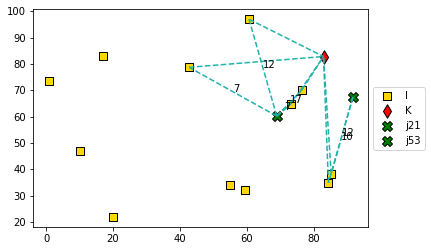

In [272]:
# plt.scatter(J['Latitude'], J['Longtitude'], color = 'blue', edgecolors = 'black',
#             marker = 'o', s = 30, label = 'J')
plt.scatter(I['Latitude'], I['Longtitude'], color = 'gold', edgecolors = 'black',
            marker = 's', s = 50, label = 'I')
plt.scatter(K['Latitude'], K['Longtitude'], color = 'red', edgecolors = 'black',
            marker = 'd', s = 90, label = 'K')


for v in model_det.getVars():
    if v.xn > 0:
        if v.varName.startswith('x_ikj'):
            indices_x = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
            plt.plot((J.loc[indices_x[2], 'Latitude'], I.loc[indices_x[0], 'Latitude']),
                     (J.loc[indices_x[2], 'Longtitude'], I.loc[indices_x[0], 'Longtitude']),
                     color = 'lightseagreen', linestyle = "--")
            plt.plot((I.loc[indices_x[0], 'Latitude'], K.loc[indices_x[1], 'Latitude']),
                     (I.loc[indices_x[0], 'Longtitude'], K.loc[indices_x[1], 'Longtitude']),
                     color = 'lightseagreen', linestyle = "--")
            plt.annotate(str(int(v.xn)), xy = ((J.loc[indices_x[2], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2,
                                               (J.loc[indices_x[2], 'Longtitude'] + I.loc[indices_x[0], 'Longtitude'])/2))
        else:
            index_y = v.varName[4:-1]
            plt.scatter(J.loc[index_y, 'Latitude'], J.loc[index_y, 'Longtitude'], color = 'green',
                        edgecolors = 'black', s = 100, marker = 'X', label = index_y)
        
            

plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))

Probabilistic model

In [273]:
theta_ran = poisson(mu)
theta_ran